# The notebook is to demonstrate Indicating problem

Generate $|z'\rangle$ from quantum part

2-regular graph with 4 nodes(a ring with $Z_4=Z_0$)
    \begin{eqnarray}
        H_c=-\sum_{i=0}^3\frac{Z_iZ_{i+1}}{2},\quad  H_b =\sum_{i=0}^3 X_i .
    \end{eqnarray}

In [3]:
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import expm

# Tensor product function
def tensor_product(*args):
    result = np.array([1])
    for arg in args:
        result = np.kron(result, arg)
    return result

# Unitary evolution operators
def unitary(H, theta):
    return expm(-1j*H*theta)


# Full circuit
def apply_circuit(gamma, beta, p, initial_state, H_c,H_b):
    state = initial_state
    # Define the Hamiltonians H_c and H_b
    for _ in range(p):
        state = unitary(H_c, gamma) @ state
        state = unitary(H_b, beta) @ state
    return state


# Cost function
def cost_function(params, p, initial_state, H_c, H_b):
    gamma, beta = params
  
    final_state = apply_circuit(gamma, beta, p, initial_state, H_c, H_b)
    expectation_value = np.real(np.vdot(final_state, H_c @ final_state))
    
    # Increment the counter and print every 10 iterations
    global iteration_counter
    iteration_counter += 1
    if iteration_counter % 10 == 0:
        print(f'Iteration: {iteration_counter}, gamma: {gamma:.4f}, beta: {beta:.4f}, cost: {expectation_value:.4f}')

    
    
    return expectation_value


def find_ground_energy(hamiltonian):
    """
    Find the ground energy of a Hamiltonian.
    
    Parameters:
    hamiltonian (np.ndarray): The Hamiltonian matrix.
    
    Returns:
    float: The ground energy (lowest eigenvalue) of the Hamiltonian.
    """
    # Calculate the eigenvalues of the Hamiltonian
    eigenvalues = np.linalg.eigvalsh(hamiltonian)
    
    # Return the smallest eigenvalue
    return np.min(eigenvalues)

Pre-train with an initial PQC, circuit formulates like this: $[e ^{-i H_b \beta}e^{-iH_c \gamma}]$

In [4]:
# Define Pauli matrices
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Initial state |+>^4 = (|0> + |1>)/sqrt(2) ⊗ 4
initial_state = tensor_product(np.array([1, 1]) / np.sqrt(2), 
                               np.array([1, 1]) / np.sqrt(2),
                               np.array([1, 1]) / np.sqrt(2),
                               np.array([1, 1]) / np.sqrt(2))
# Define the Hamiltonians H_c and H_b
H_c = -(tensor_product(Z, Z, I, I)+tensor_product(I, Z, Z, I)+tensor_product(I, I, Z, Z)+tensor_product(Z, I, I, Z))
H_b = tensor_product(X, I, I, I)+tensor_product(I, X, I, I)+tensor_product(I, I, X, I)+tensor_product(I, I, I, X)  

# Global iteration counter
iteration_counter = 0

# Optimize using scipy
p = 1  # Number of layers
initial_params = np.random.rand(2)  # Initial guess for gamma and beta

result = minimize(cost_function, initial_params, args=(p,initial_state, H_c, H_b,), method='COBYLA')
optimal_gamma, optimal_beta = result.x

print(f'Optimal gamma: {optimal_gamma}, Optimal beta: {optimal_beta}')


temp_eig3 = find_ground_energy(H_c)
print(temp_eig3)

Iteration: 10, gamma: 1.6447, beta: -0.6786, cost: -0.2415
Iteration: 20, gamma: 1.9870, beta: -0.4104, cost: -1.9862
Iteration: 30, gamma: 1.9670, beta: -0.3893, cost: -1.9996
Iteration: 40, gamma: 1.9636, beta: -0.3928, cost: -2.0000
Optimal gamma: 1.9634334189586444, Optimal beta: -0.39257175710456876
-4.0


Then, using quantum gradient algorithm, we can obtain an updated $|z'\rangle$

In [5]:
def fidelity(state1, state2):

    state1 = np.asarray(state1)
    state2 = np.asarray(state2)
    
#     print(np.vdot(state1, state1))
    # Normalize the states
    state1 = state1 / np.linalg.norm(state1)
    state2 = state2 / np.linalg.norm(state2)
    
    # Calculate the fidelity
    fidelity_value = np.abs(np.vdot(state1, state2))**2
    
    return fidelity_value


def gradient(hamiltonian, xi):
    """
    Compute the gradient of the Hamiltonian with respect to a parameter.

    Parameters:
    hamiltonian (numpy.ndarray): The Hamiltonian matrix.
    xi (float): The scalar value representing the parameter with respect to which 
                the gradient is being computed.

    Returns:
    numpy.ndarray: The gradient matrix, which is the Hamiltonian scaled by the parameter xi.
    """
    
    # Compute the gradient by scaling the Hamiltonian with the parameter xi
    gradient = xi * hamiltonian
    
    # Return the resulting gradient matrix
    return gradient

# def PQC_RL(env, train_steps):
#     """
#     Compute parameterized quantum circuit that tranform state_in to state_out.

#     Parameters:
#         env (): the defined environment with correspoding initial and target state.

#     Returns:
#         info (dict): with key 'fidelity', 'circuit'
#         ...: the learned policy.
#     """


#     # Parameters
#     gamma = 0.99
#     n_epochs = 4
#     clip_range = 0.2
#     learning_rate = 0.0001
#     policy_kwargs = dict(optimizer_class=optim.Adam)

#     # Agent
#     ppo_model = PPO("MlpPolicy",
#                     env,
#                     gamma=gamma,
#                     n_epochs=n_epochs,
#                     clip_range=clip_range,
#                     learning_rate=learning_rate,
#                     policy_kwargs=policy_kwargs,
#                     tensorboard_log='logs/')
    
#     ppo_model.learn(total_timesteps=train_steps)
    
#     # simulate to get fidelity
#     state = env.reset()
#     # print(state)
#     done = False
#     while not done:
#         action = ppo_model.predict(state)
#         state, reward, done, info = env.step(action[0])
#         #展示当前的线路 和 state
#         # env.render()
#         # print(state)
#         # print(info['fidelity'])
#     return info,ppo_model

def PQC_RL(env, learn_steps, state_in, f_in):
    """
    Compute parameterized quantum circuit that tranform state_in to state_out.

    Parameters:
        env (environment): the defined qas_env environment with corresponding initial and target state.
        learn_steps: number of episodes to learn policy
        state_in: initial state
        f_in: initial fidelity  (the logic is if the best fidelity value after learning is no better that the initial value, then return the initial state)

    Returns:
        max_fstate: state with max fidelity
        max_fidelity: max fidelity with learned policy
    """


    # Parameters
    gamma = 0.99
    n_epochs = 4
    clip_range = 0.2
    learning_rate = 0.0001
    policy_kwargs = dict(optimizer_class=optim.Adam)

    # Agent
    ppo_model = PPO("MlpPolicy",
                    env,
                    gamma=gamma,
                    n_epochs=n_epochs,
                    clip_range=clip_range,
                    learning_rate=learning_rate,
                    policy_kwargs=policy_kwargs,
                    tensorboard_log='logs/')
    
    ppo_model.learn(total_timesteps=learn_steps)
    
    # simulate to get fidelity
    state = env.reset()

    # set max_fidelity, max_fstate to the initial value
    max_fidelity = f_in
    max_fstate = state_in

    done = False
    while not done:
        action = ppo_model.predict(state)
        state, reward, done, info = env.step(action[0])
        #展示当前的线路 和 state
        # env.render()
        # print(state)
        # print(info['fidelity'])
        if info['fidelity'] > max_fidelity:
            max_fidelity = info['fidelity']
            max_fstate = info['state']
    return max_fstate, max_fidelity




In [6]:
import gym
import numpy as np
from stable_baselines3.common.evaluation import evaluate_policy
import qas_gym
import warnings
# import sys
from stable_baselines3 import PPO
import torch.optim as optim


In [7]:

env_name = 'BasicFourQubit-v0' # 四比特环境-无噪声
reward_penalty = 0.01
max_depth = 10
xi=0.2
state_in=apply_circuit(optimal_gamma, optimal_beta, p, initial_state, H_c, H_b)
state_out=state_in-gradient(H_c, xi)@state_in

state_out = state_out/np.linalg.norm(state_out)

# # print(state_out)

f_ini = fidelity(state_out, state_in)
print("Initial fidelity {:.4f}: ".format(f_ini))
fidelity_threshold = 0.99 # min(0.99, f_ini*1.2)
# print("fidelity_threshold:", fidelity_threshold )

## Influence of number of learning episodes on learned policy

# test_iters = [10000,20000,50000,100000] #
# num_runs = 5
# fresult = np.zeros((len(test_iters), num_runs))

# for i,ts in enumerate(test_iters):
#     for n in range(num_runs):
#         # expectation_value = np.real(np.vdot(state_out, H_c @ state_out))
#         # print(expectation_value)
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             # state_in, fidelity_j = get_PQC_state(state_in, state_out,fidelity_threshold=fidelity_threshold,train_steps=ts)
#             env = gym.make(env_name, target = state_out,
#                     fidelity_threshold=fidelity_threshold,
#                     reward_penalty=reward_penalty,
#                     max_timesteps=max_depth,
#                     initial = state_in)
#             f_ini = fidelity(state_out, state_in)
        
#             _, fidelity_j = PQC_RL(env, ts, state_in, f_ini)
#         fresult[i, n] = fidelity_j
#         print("Fidelity after classical learning PQC: {:.4f}".format(fidelity_j))


Initial fidelity 0.9074: 


In [8]:
# Influence of max circuit depth on learned policy
test_max_depth = [10, 15, 20]
num_runs = 5
fresult = np.zeros((len(test_max_depth), num_runs))
fidelity_threshold = 0.99

for i,td in enumerate(test_max_depth):
    for n in range(num_runs):
        # expectation_value = np.real(np.vdot(state_out, H_c @ state_out))
        # print(expectation_value)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # state_in, fidelity_j = get_PQC_state(state_in, state_out,fidelity_threshold=fidelity_threshold,train_steps=ts)
            env = gym.make(env_name, target = state_out,
                    fidelity_threshold=fidelity_threshold,
                    reward_penalty=reward_penalty,
                    max_timesteps=td,
                    initial = state_in)
            f_ini = fidelity(state_out, state_in)
        
            _, fidelity_j = PQC_RL(env, 100000, state_in, f_ini)
        fresult[i, n] = fidelity_j
        print("Fidelity after classical learning PQC: {:.4f}".format(fidelity_j))

Fidelity after classical learning PQC: 0.9551
Fidelity after classical learning PQC: 0.9761
Fidelity after classical learning PQC: 0.9576
Fidelity after classical learning PQC: 0.9765


In [ ]:

# loop of quantum gradient and classical learning 

xi=0.2
state_in=apply_circuit(optimal_gamma, optimal_beta, p, initial_state, H_c, H_b)

env_name = 'BasicFourQubit-v0' # 四比特环境-无噪声
reward_penalty = 0.01
# max_timesteps = 5
max_depth = 10
max_iter = 5
for i in range(max_iter):
    print("\n------------------ Iteration {}: ----------------------".format(i))
    #initial state from the last classical learning
    # if i>0: 
    #     state_in = info['state']

    state_out=state_in-gradient(H_c, xi)@state_in

    state_out = state_out/np.linalg.norm(state_out)

    # # print(state_out)

    f_ini = fidelity(state_out, state_in)
    print("Initial fidelity {:.4f}: ".format(f_ini))
    fidelity_threshold = 0.99 #min(0.99, f_ini*1.2)
    print("fidelity_threshold:", fidelity_threshold )

    # fidelity(state_out, state_out_pqc)

    # expectation_value = np.real(np.vdot(state_out, H_c @ state_out))
    # print(expectation_value)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        state_in, fidelity_j = get_PQC_state(state_in, state_out)

    
    print("Fidelity after classical learning PQC: {:.4f}".format(fidelity_j))


In [53]:
fresult_02_0999 = fresult
# fresult_04_0999[:,0] = fresult.reshape((4,))


In [ ]:
# initial fidelity
# xi_02：0.9074
# xi_04:  0.8020


array([0.97512957, 0.97512957, 0.97512957])

In [6]:
import pickle
# f = open('result/test_learningPQC_negreward02.pkl', 'wb')
# pickle.dump(fresult_02_0999, f)
# f = open('result/test_learningPQC_negreward02.pkl', 'rb')
# fresult_02_0999 = pickle.load(f)
# f.close()
f = open('result/test_learningPQC_negreward04.pkl', 'rb')
fresult_04_0999 = pickle.load(f)
f.close()

# dill.dump_session('test_learningPQC.db')

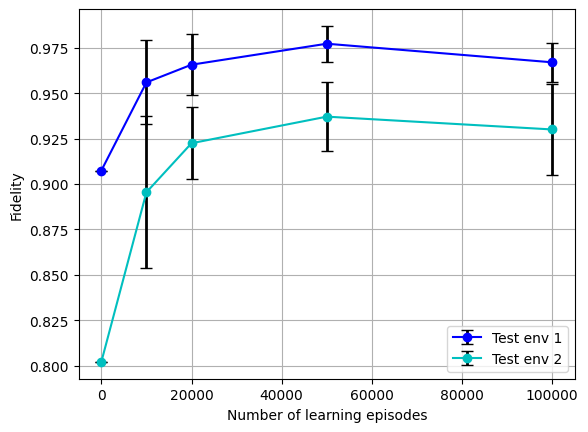

In [22]:
import matplotlib.pyplot as plt
import numpy as np
#fmt :   'o' ',' '.' 'x' '+' 'v' '^' '<' '>' 's' 'd' 'p'

x=(np.array([0,10000,20000,50000,100000])) #np.log2
y = np.zeros(len(x))
y[0] = 0.9074
y[1:] = np.mean(fresult_02_0999, axis = 1)
dy=np.zeros(len(x))
dy[0] = 0
dy[1:] = np.std(fresult_02_0999, axis = 1)
plt.errorbar(x,y,yerr=dy,fmt='o-',ecolor='k',color='b',elinewidth=2,capsize=4) #


y2 = np.zeros(len(x))
y2[0] = 0.8020
y2[1:] = np.mean(fresult_04_0999, axis = 1)
dy2=np.zeros(len(x))
dy2[0] = 0
dy2[1:] = np.std(fresult_04_0999, axis = 1)
plt.errorbar(x,y2,yerr=dy2,fmt='o-',ecolor='k',color='c',elinewidth=2,capsize=4)

# x=(np.array([10000,20000,50000,100000])) #np.log2
# y=np.mean(fresult_04_0999, axis = 1)
# dy=np.std(fresult_04_0999, axis = 1)
# plt.errorbar(x,y,yerr=dy,fmt='o-',ecolor='r',color='b',elinewidth=2,capsize=4)

plt.legend(['Test env 1', 'Test env 2'])

plt.ylabel('Fidelity')

plt.xlabel('Number of learning episodes')

plt.grid(True)
plt.savefig("testRL_1.pdf", format='pdf', bbox_inches='tight')

# plt.show()
